1. 데이터 로드 및 전처리

In [10]:
import pandas as pd
# CSV 데이터 로드
file_path = '경찰청_범죄자 생활정도, 혼인관계 및 부모관계_12_31_2020.csv'  # 파일 경로
data = pd.read_csv(file_path, encoding='cp949')  # 필요 시 cp949로 변경



# 데이터 확인
print(data.head())


   범죄중분류  생활정도(계)  생활정도(하류)  생활정도(중류)  생활정도(상류)  생활정도(미상)  혼인관계(계)  혼인관계(소계)  \
0   살인기수      341       172        72         6        91      341       158   
1  살인미수등      454       276        93         3        82      454       234   
2     강도     1202       713       327        15       147     1202       257   
3     강간     6113      1831      1987        78      2217     6113      1295   
4   유사강간      934       331       362         7       234      934       236   

   혼인관계(유배우자)  혼인관계(동거)  ...  미혼자부모관계(실(양)부모)  미혼자부모관계(계부모)  미혼자부모관계(실부계모)  \
0          81         7  ...               45             0              2   
1         123        19  ...               82             1              0   
2         144        23  ...              615             2              8   
3         798        65  ...             1998             8             23   
4         145         9  ...              352             1              4   

   미혼자부모관계(실부무모)  미혼자부모관계(실모계부)  미혼자부모관계(실모무부)  미혼

2. 불리언 변환
생활정도, 혼인관계, 미혼자부모관계와 같은 속성을 "있음(1)" 또는 "없음(0)"으로 변환합니다.

In [11]:
# 불리언 변환

# 범죄중분류를 원핫 인코딩으로 변환
encoded_data = pd.get_dummies(data['범죄중분류'])
binary_data = pd.concat([encoded_data, data.iloc[:, 2:]], axis=1)  # 범죄중분류 + 나머지 속성

for col in data.columns[2:]:  # 범죄중분류 이후의 속성들만 변환
    binary_data[col] = data[col] > 0  # 0보다 크면 True, 아니면 False

# 희소 데이터 제거 (너무 자주 등장하는 항목 제거)
columns_to_keep = binary_data.columns[binary_data.mean() < 0.9]
binary_data = binary_data[columns_to_keep]

# 데이터 샘플링 (10% 샘플링)
binary_data_sample = binary_data.sample(frac=0.1, random_state=42)

3. Apriori 알고리즘을 사용해 빈발 항목 집합 생성

In [12]:
from mlxtend.frequent_patterns import apriori

# Apriori 실행 (min_support 및 max_len 설정)
frequent_itemsets = apriori(binary_data, min_support=0.4, max_len=2, use_colnames=True)

print("Frequent Itemsets:")
print(frequent_itemsets.head())


Frequent Itemsets:
    support         itemsets
0  0.710526   (미혼자부모관계(계부모))
1  0.710526  (미혼자부모관계(실부계모))
2  0.763158  (미혼자부모관계(실모계부))
3  0.500000  (미혼자부모관계(계부무모))
4  0.605263  (미혼자부모관계(계모무부))


4. 연관 규칙 생성

In [13]:
from mlxtend.frequent_patterns import association_rules

# 빈발 항목 집합의 개수 계산
num_itemsets = len(frequent_itemsets)
print("num_itemsets: " + str(num_itemsets))
# 연관 규칙 생성
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5, num_itemsets=num_itemsets)
print("Top 10 Rules: " + str(rules.head(10)))



num_itemsets: 15
Top 10 Rules:        antecedents      consequents  antecedent support  consequent support  \
0   (미혼자부모관계(계부모))  (미혼자부모관계(실부계모))            0.710526            0.710526   
1  (미혼자부모관계(실부계모))   (미혼자부모관계(계부모))            0.710526            0.710526   
2   (미혼자부모관계(계부모))  (미혼자부모관계(실모계부))            0.710526            0.763158   
3  (미혼자부모관계(실모계부))   (미혼자부모관계(계부모))            0.763158            0.710526   
4   (미혼자부모관계(계부모))  (미혼자부모관계(계부무모))            0.710526            0.500000   
5  (미혼자부모관계(계부무모))   (미혼자부모관계(계부모))            0.500000            0.710526   
6   (미혼자부모관계(계부모))  (미혼자부모관계(계모무부))            0.710526            0.605263   
7  (미혼자부모관계(계모무부))   (미혼자부모관계(계부모))            0.605263            0.710526   
8  (미혼자부모관계(실모계부))  (미혼자부모관계(실부계모))            0.763158            0.710526   
9  (미혼자부모관계(실부계모))  (미혼자부모관계(실모계부))            0.710526            0.763158   

    support  confidence      lift  representativity  leverage  conviction  \
0  0.657895    0.92592

5-1. 시각화
Support vs Confidence
규칙의 지지도(Support)와 신뢰도(Confidence)를 시각화합니다.

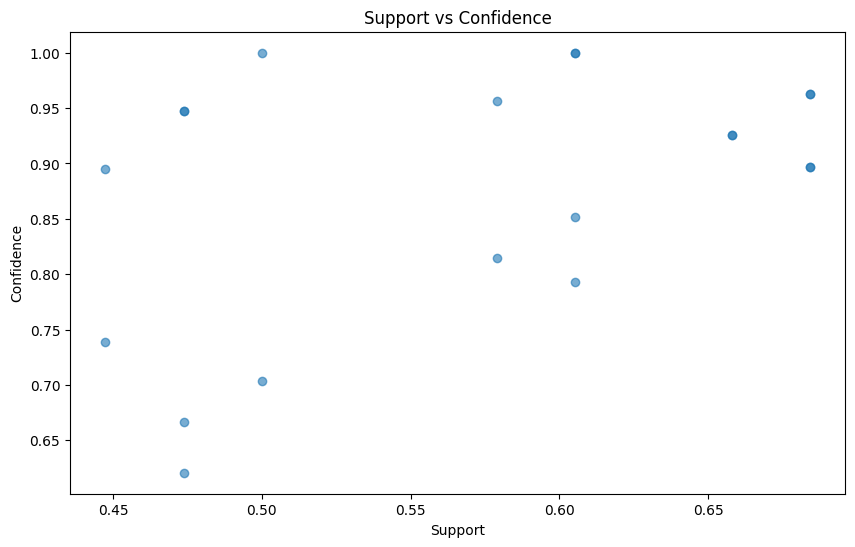

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(rules['support'], rules['confidence'], alpha=0.6)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence')
plt.show()


5-2. Lift 분포
규칙의 향상도(Lift) 분포를 시각화합니다.

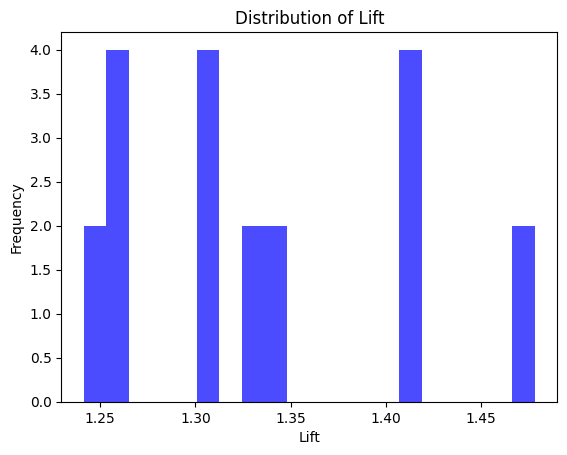

In [15]:
plt.hist(rules['lift'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Lift')
plt.ylabel('Frequency')
plt.title('Distribution of Lift')
plt.show()


6. 결과 해석
생성된 연관 규칙에서 범죄 항목간의 관계를 분석합니다.
상위 Lift 기반 규칙 출력
향상도(Lift)가 높은 상위 10개의 규칙을 출력합니다.

In [16]:
top_lift_rules = rules.sort_values('lift', ascending=False).head(10)
print("Top 10 Rules by Lift:")
print(top_lift_rules)


Top 10 Rules by Lift:
        antecedents      consequents  antecedent support  consequent support  \
18  (미혼자부모관계(계모무부))  (미혼자부모관계(계부무모))            0.605263            0.500000   
19  (미혼자부모관계(계부무모))  (미혼자부모관계(계모무부))            0.500000            0.605263   
5   (미혼자부모관계(계부무모))   (미혼자부모관계(계부모))            0.500000            0.710526   
4    (미혼자부모관계(계부모))  (미혼자부모관계(계부무모))            0.710526            0.500000   
6    (미혼자부모관계(계부모))  (미혼자부모관계(계모무부))            0.710526            0.605263   
7   (미혼자부모관계(계모무부))   (미혼자부모관계(계부모))            0.605263            0.710526   
13  (미혼자부모관계(실부계모))  (미혼자부모관계(계모무부))            0.710526            0.605263   
12  (미혼자부모관계(계모무부))  (미혼자부모관계(실부계모))            0.605263            0.710526   
10  (미혼자부모관계(계부무모))  (미혼자부모관계(실부계모))            0.500000            0.710526   
11  (미혼자부모관계(실부계모))  (미혼자부모관계(계부무모))            0.710526            0.500000   

     support  confidence      lift  representativity  leverage  conviction  \
18  0.447368    0.7